In [1]:
import numpy as np
import sys
sys.path.append('./ckplotlib/')
import map_funcs
from IPython.display import Image
#
import xarray as xr
import xesmf as xe
import smoothlib
import geog_funcs

import warnings; warnings.simplefilter('ignore')


1.6.1


In [2]:
models_list = (
    'CanESM5',
    'CESM2',
    'CNRM-ESM2-1',
    'GISS-E2-1-G'
    )

exps_list = ('piControl','1pctco2-bgc','1pctco2')

vars_list = ('tas','fgco2','netAtmosLandCO2Flux')

nmodels = len(models_list)
nvars = len(vars_list)
nexps = len(exps_list)

file_master_list_dynamics = [[[[] for i in range(nexps )] for j in range(nvars)] for k in range(nmodels)]
### index this file as [model_i][var_i][exp_i]

y_4xco2 = 140 - 1
t_4xco2 = (y_4xco2+1)*12-1


regrid_lons = np.arange(-179.5,180.5,1.)
regrid_lats = np.arange(-89.5,90.5,1.)

IM_o = len(regrid_lons)
JM_o = len(regrid_lats)

# make a dataset on the new grid
ds_out = xr.Dataset({'lat': (['lat'], regrid_lats),
                     'lon': (['lon'], regrid_lons),
                    })

### assume uniform CO2 trajectories as if all the models followed the protocol
pico2 = 284.7
delta_co2_ppm_4xco2 = 3.*pico2

In [3]:
### load all the files for CESM2

model_i = models_list.index('CESM2')

file_master_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('piControl')] = [
    'tas_Amon_CESM2_piControl_r1i1p1f1_gn_050001-059912.nc',
    'tas_Amon_CESM2_piControl_r1i1p1f1_gn_060001-069912.nc'
]

file_master_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('1pctco2-bgc')] = [
    'tas_Amon_CESM2_1pctCO2-bgc_r1i1p1f1_gn_000101-005012.nc',
    'tas_Amon_CESM2_1pctCO2-bgc_r1i1p1f1_gn_005101-010012.nc',
    'tas_Amon_CESM2_1pctCO2-bgc_r1i1p1f1_gn_010101-015012.nc'
]

file_master_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('1pctco2')] = [
    'tas_Amon_CESM2_1pctCO2_r1i1p1f1_gn_000101-005012.nc',
    'tas_Amon_CESM2_1pctCO2_r1i1p1f1_gn_005101-010012.nc',
    'tas_Amon_CESM2_1pctCO2_r1i1p1f1_gn_010101-015012.nc'
]

file_master_list_dynamics[model_i][vars_list.index('netAtmosLandCO2Flux')][exps_list.index('piControl')] = [
    'netAtmosLandCO2Flux_Emon_CESM2_piControl_r1i1p1f1_gn_050001-059912.nc',
    'netAtmosLandCO2Flux_Emon_CESM2_piControl_r1i1p1f1_gn_060001-069912.nc'
]

file_master_list_dynamics[model_i][vars_list.index('netAtmosLandCO2Flux')][exps_list.index('1pctco2-bgc')] = [
    'netAtmosLandCO2Flux_Emon_CESM2_1pctCO2-bgc_r1i1p1f1_gn_000101-005012.nc',
    'netAtmosLandCO2Flux_Emon_CESM2_1pctCO2-bgc_r1i1p1f1_gn_005101-010012.nc',
    'netAtmosLandCO2Flux_Emon_CESM2_1pctCO2-bgc_r1i1p1f1_gn_010101-015012.nc'
]

file_master_list_dynamics[model_i][vars_list.index('netAtmosLandCO2Flux')][exps_list.index('1pctco2')] = [
    'netAtmosLandCO2Flux_Emon_CESM2_1pctCO2_r1i1p1f1_gn_000101-005012.nc',
    'netAtmosLandCO2Flux_Emon_CESM2_1pctCO2_r1i1p1f1_gn_005101-010012.nc',
    'netAtmosLandCO2Flux_Emon_CESM2_1pctCO2_r1i1p1f1_gn_010101-015012.nc'
]

file_master_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('piControl')] = [
    'fgco2_Omon_CESM2_piControl_r1i1p1f1_gn_050001-059912.nc',
    'fgco2_Omon_CESM2_piControl_r1i1p1f1_gn_060001-069912.nc'
]

file_master_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('1pctco2-bgc')] = [
    'fgco2_Omon_CESM2_1pctCO2-bgc_r1i1p1f1_gn_000101-005012.nc',
    'fgco2_Omon_CESM2_1pctCO2-bgc_r1i1p1f1_gn_005101-010012.nc',
    'fgco2_Omon_CESM2_1pctCO2-bgc_r1i1p1f1_gn_010101-015012.nc'
]

file_master_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('1pctco2')] = [
    'fgco2_Omon_CESM2_1pctCO2_r1i1p1f1_gn_000101-005012.nc',
    'fgco2_Omon_CESM2_1pctCO2_r1i1p1f1_gn_005101-010012.nc',
    'fgco2_Omon_CESM2_1pctCO2_r1i1p1f1_gn_010101-015012.nc'
]

In [4]:
### load all the files for CanESM5

model_i = models_list.index('CanESM5')

file_master_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('piControl')] = [
'tas_Amon_CanESM5_piControl_r1i1p1f1_gn_520101-540012.nc',
'tas_Amon_CanESM5_piControl_r1i1p1f1_gn_540101-560012.nc'
]

file_master_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('1pctco2-bgc')] = [
'tas_Amon_CanESM5_1pctCO2-bgc_r1i1p1f1_gn_185001-200012.nc'
]

file_master_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('1pctco2')] = [
'tas_Amon_CanESM5_1pctCO2_r1i1p1f1_gn_185001-200012.nc'
]

file_master_list_dynamics[model_i][vars_list.index('netAtmosLandCO2Flux')][exps_list.index('piControl')] = [
'netAtmosLandCO2Flux_Emon_CanESM5_piControl_r1i1p1f1_gn_520101-540012.nc',
'netAtmosLandCO2Flux_Emon_CanESM5_piControl_r1i1p1f1_gn_540101-560012.nc'
]

file_master_list_dynamics[model_i][vars_list.index('netAtmosLandCO2Flux')][exps_list.index('1pctco2-bgc')] = [
'netAtmosLandCO2Flux_Emon_CanESM5_1pctCO2-bgc_r1i1p1f1_gn_185001-200012.nc'
]

file_master_list_dynamics[model_i][vars_list.index('netAtmosLandCO2Flux')][exps_list.index('1pctco2')] = [
'netAtmosLandCO2Flux_Emon_CanESM5_1pctCO2_r1i1p1f1_gn_185001-200012.nc'
]

file_master_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('piControl')] = [
'fgco2_Omon_CanESM5_piControl_r1i1p1f1_gn_520101-540012.nc',
'fgco2_Omon_CanESM5_piControl_r1i1p1f1_gn_540101-560012.nc'
]

file_master_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('1pctco2-bgc')] = [
'fgco2_Omon_CanESM5_1pctCO2-bgc_r1i1p1f1_gn_185001-200012.nc'
]

file_master_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('1pctco2')] = [
'fgco2_Omon_CanESM5_1pctCO2_r1i1p1f1_gn_185001-200012.nc'
]

In [5]:
### load all the files for GISS-E2-1-G

model_i = models_list.index('GISS-E2-1-G')

file_master_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('piControl')] = [
'tas_Amon_GISS-E2-1-G_piControl_r1i1p1f1_gn_415001-420012.nc',
'tas_Amon_GISS-E2-1-G_piControl_r1i1p1f1_gn_420101-425012.nc',
'tas_Amon_GISS-E2-1-G_piControl_r1i1p1f1_gn_425101-430012.nc'
]

file_master_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('1pctco2-bgc')] = [
'tas_Amon_GISS-E2-1-G_1pctCO2-bgc_r101i1p1f1_gn_185001-190012.nc',
'tas_Amon_GISS-E2-1-G_1pctCO2-bgc_r101i1p1f1_gn_190101-195012.nc',
'tas_Amon_GISS-E2-1-G_1pctCO2-bgc_r101i1p1f1_gn_195101-200012.nc'
]

file_master_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('1pctco2')] = [
'tas_Amon_GISS-E2-1-G_1pctCO2_r1i1p1f1_gn_185001-190012.nc',
'tas_Amon_GISS-E2-1-G_1pctCO2_r1i1p1f1_gn_190101-195012.nc',
'tas_Amon_GISS-E2-1-G_1pctCO2_r1i1p1f1_gn_195101-200012.nc'
]

file_master_list_dynamics[model_i][vars_list.index('netAtmosLandCO2Flux')][exps_list.index('piControl')] = [
'nbp_Lmon_GISS-E2-1-G_piControl_r101i1p1f1_gn_185001-190012.nc',
'nbp_Lmon_GISS-E2-1-G_piControl_r101i1p1f1_gn_190101-195012.nc',
'nbp_Lmon_GISS-E2-1-G_piControl_r101i1p1f1_gn_195101-200012.nc'
]

file_master_list_dynamics[model_i][vars_list.index('netAtmosLandCO2Flux')][exps_list.index('1pctco2-bgc')] = [
'nbp_Lmon_GISS-E2-1-G_1pctCO2-bgc_r101i1p1f1_gn_185001-190012.nc',
'nbp_Lmon_GISS-E2-1-G_1pctCO2-bgc_r101i1p1f1_gn_190101-195012.nc',
'nbp_Lmon_GISS-E2-1-G_1pctCO2-bgc_r101i1p1f1_gn_195101-200012.nc'
]

file_master_list_dynamics[model_i][vars_list.index('netAtmosLandCO2Flux')][exps_list.index('1pctco2')] = [
'nbp_Lmon_GISS-E2-1-G_1pctCO2_r101i1p1f1_gn_185001-190012.nc',
'nbp_Lmon_GISS-E2-1-G_1pctCO2_r101i1p1f1_gn_190101-195012.nc',
'nbp_Lmon_GISS-E2-1-G_1pctCO2_r101i1p1f1_gn_195101-200012.nc'
]

file_master_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('piControl')] = [
'fgco2_Omon_GISS-E2-1-G_piControl_r101i1p1f1_gn_185001-190012.nc',
'fgco2_Omon_GISS-E2-1-G_piControl_r101i1p1f1_gn_190101-195012.nc',
'fgco2_Omon_GISS-E2-1-G_piControl_r101i1p1f1_gn_195101-200012.nc'
]

file_master_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('1pctco2-bgc')] = [
'fgco2_Omon_GISS-E2-1-G_1pctCO2-bgc_r101i1p1f1_gn_185001-190012.nc',
'fgco2_Omon_GISS-E2-1-G_1pctCO2-bgc_r101i1p1f1_gn_190101-195012.nc',
'fgco2_Omon_GISS-E2-1-G_1pctCO2-bgc_r101i1p1f1_gn_195101-200012.nc'
]

file_master_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('1pctco2')] = [
'fgco2_Omon_GISS-E2-1-G_1pctCO2_r101i1p1f1_gn_185001-190012.nc',
'fgco2_Omon_GISS-E2-1-G_1pctCO2_r101i1p1f1_gn_190101-195012.nc',
'fgco2_Omon_GISS-E2-1-G_1pctCO2_r101i1p1f1_gn_195101-200012.nc'
]

In [6]:
### load all the files for CNRM-ESM2-1
model_i = models_list.index('CNRM-ESM2-1')

file_master_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('piControl')] = [
'tas_Amon_CNRM-ESM2-1_piControl_r1i1p1f2_gr_185001-234912.nc'
]

file_master_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('1pctco2-bgc')] = [
'tas_Amon_CNRM-ESM2-1_1pctCO2-bgc_r1i1p1f2_gr_185001-198912.nc'
]

file_master_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('1pctco2')] = [
'tas_Amon_CNRM-ESM2-1_1pctCO2_r1i1p1f2_gr_185001-199912.nc'
]

file_master_list_dynamics[model_i][vars_list.index('netAtmosLandCO2Flux')][exps_list.index('piControl')] = [
'netAtmosLandCO2Flux_Emon_CNRM-ESM2-1_piControl_r1i1p1f2_gr_185001-234912.nc'
]

file_master_list_dynamics[model_i][vars_list.index('netAtmosLandCO2Flux')][exps_list.index('1pctco2-bgc')] = [
'netAtmosLandCO2Flux_Emon_CNRM-ESM2-1_1pctCO2-bgc_r1i1p1f2_gr_185001-198912.nc'
]

file_master_list_dynamics[model_i][vars_list.index('netAtmosLandCO2Flux')][exps_list.index('1pctco2')] = [
'netAtmosLandCO2Flux_Emon_CNRM-ESM2-1_1pctCO2_r1i1p1f2_gr_185001-199912.nc'
]

file_master_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('piControl')] = [
'fgco2_Omon_CNRM-ESM2-1_piControl_r1i1p1f2_gn_185001-234912.nc'
]

file_master_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('1pctco2-bgc')] = [
'fgco2_Omon_CNRM-ESM2-1_1pctCO2-bgc_r1i1p1f2_gn_185001-198912.nc'
]

file_master_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('1pctco2')] = [
'fgco2_Omon_CNRM-ESM2-1_1pctCO2_r1i1p1f2_gn_185001-199912.nc'
]

In [7]:
### load tas for all models and calcjulate the global mean temperature trajectories
i_var = vars_list.index('tas')
tas_trajectories = []
for model_i in range(nmodels):
    print(models_list[model_i])
    tas_trajectories.append([])
    for exp_i in range(nexps):
        dataset = xr.open_mfdataset(file_master_list_dynamics[model_i][i_var][exp_i])
        tasvar = dataset['tas']
        tas_annual = smoothlib.monthly_to_annual_xarray(tasvar).compute()
        tas_annual_globalmean = geog_funcs.area_average(tas_annual.data[:], tasvar.coords['lat'].data[:], tasvar.coords['lon'].data[:])
        tas_trajectories[model_i].append(tas_annual_globalmean[y_4xco2-10:y_4xco2].mean())


CanESM5
CESM2
CNRM-ESM2-1
GISS-E2-1-G


In [8]:
colorbar_levels_beta = np.arange(-2.e-2,2.e-2,1e-3)
colorbar_levels_gamma = np.arange(-1.,1.,.1)

In [9]:
### load netAtmosLandCO2Flux for all models
i_var = vars_list.index('netAtmosLandCO2Flux')
beta_land_regridded_maps = []
gamma_land_regridded_maps = []
for model_i in range(nmodels):
    land_flux_maps = []
    for exp_i in range(nexps):
        dataset = xr.open_mfdataset(file_master_list_dynamics[model_i][i_var][exp_i])
        #dataset = dataset.rename_vars({'lat_bnds': 'lat_b', 'lon_bnds': 'lon_b'})
        regridder = xe.Regridder(dataset, ds_out, 'nearest_s2d', reuse_weights=True)
        try:
            netAtmosLandCO2Flux = dataset['netAtmosLandCO2Flux']
        except:
            netAtmosLandCO2Flux = dataset['nbp']
        integrated_landco2flux = smoothlib.monthly_to_annual_xarray(netAtmosLandCO2Flux).cumsum(axis=0)[y_4xco2,:,:] * 86400. * 365.
        land_flux_maps.append(integrated_landco2flux.copy())        
    beta = (land_flux_maps[exps_list.index('1pctco2-bgc')] - land_flux_maps[exps_list.index('piControl')]) / delta_co2_ppm_4xco2
    gamma = (land_flux_maps[exps_list.index('1pctco2')] - land_flux_maps[exps_list.index('1pctco2-bgc')]) / (tas_trajectories[model_i][exps_list.index('1pctco2')] - tas_trajectories[model_i][exps_list.index('piControl')])
    #map_funcs.fill(beta.data[:], beta.coords['lat'].data, beta.coords['lon'].data, showjupyter=True, levels=colorbar_levels_beta, colormap='MPL_PiYG', projection='Robinson')
    #map_funcs.fill(gamma.data[:], gamma.coords['lat'].data, gamma.coords['lon'].data, showjupyter=True, levels=colorbar_levels_gamma, colormap='MPL_PiYG', projection='Robinson')
    #map_funcs.fill(regridder(beta).data[:], regrid_lats, regrid_lons, showjupyter=True, levels=colorbar_levels_beta, colormap='MPL_PiYG', projection='Robinson', title='Beta Land: '+models_list[model_i], subtitle = 'kg C m~S~-2~N~ ppm~S~-1~N~')
    #map_funcs.fill(regridder(gamma).data[:], regrid_lats, regrid_lons, showjupyter=True, levels=colorbar_levels_gamma, colormap='MPL_PiYG', projection='Robinson', title='Gamma Land: '+models_list[model_i], subtitle = 'kg C m~S~-2~N~ ~S~o~N~C~S~-1~N~')
    beta_land_regridded_maps.append(regridder(beta).data[:])
    gamma_land_regridded_maps.append(regridder(gamma).data[:])

Reuse existing file: nearest_s2d_64x128_180x360.nc
Reuse existing file: nearest_s2d_64x128_180x360.nc
Reuse existing file: nearest_s2d_64x128_180x360.nc
Reuse existing file: nearest_s2d_192x288_180x360.nc
Reuse existing file: nearest_s2d_192x288_180x360.nc
Reuse existing file: nearest_s2d_192x288_180x360.nc
Reuse existing file: nearest_s2d_128x256_180x360.nc
Reuse existing file: nearest_s2d_128x256_180x360.nc
Reuse existing file: nearest_s2d_128x256_180x360.nc
Reuse existing file: nearest_s2d_90x144_180x360.nc
Reuse existing file: nearest_s2d_90x144_180x360.nc
Reuse existing file: nearest_s2d_90x144_180x360.nc


In [10]:
### load netAtmosLandCO2Flux for all models
i_var = vars_list.index('fgco2')
beta_ocean_regridded_maps = []
gamma_ocean_regridded_maps = []
for model_i in range(nmodels):
    ocean_flux_maps = []
    for exp_i in range(nexps):
        dataset = xr.open_mfdataset(file_master_list_dynamics[model_i][i_var][exp_i])
        #print(dataset)
        #print(dataset.dims)
        #print(dataset.variables)
        #dataset = dataset.rename_vars({'lat_bnds': 'lat_b', 'lon_bnds': 'lon_b'})
        try:
            dataset = dataset.rename({'longitude': 'lon', 'latitude': 'lat'})
        except:
            print('not latitude/longitude')
        regridder = xe.Regridder(dataset, ds_out, 'nearest_s2d', reuse_weights=True)
        fgco2 = dataset['fgco2']
        integrated_oceanco2flux = smoothlib.monthly_to_annual_xarray(fgco2).cumsum(axis=0)[y_4xco2,:,:] * 86400. * 365.
        ocean_flux_maps.append(integrated_oceanco2flux.copy())
    beta = (ocean_flux_maps[exps_list.index('1pctco2-bgc')] - ocean_flux_maps[exps_list.index('piControl')]) / delta_co2_ppm_4xco2
    gamma = (ocean_flux_maps[exps_list.index('1pctco2')] - ocean_flux_maps[exps_list.index('1pctco2-bgc')]) / (tas_trajectories[model_i][exps_list.index('1pctco2')] - tas_trajectories[model_i][exps_list.index('piControl')])
    #map_funcs.fill(beta.data[:], beta.coords['lat'].data, beta.coords['lon'].data, showjupyter=True, levels=colorbar_levels_beta, colormap='MPL_PiYG', projection='Robinson')
    #map_funcs.fill(gamma.data[:], gamma.coords['lat'].data, gamma.coords['lon'].data, showjupyter=True, levels=colorbar_levels_gamma, colormap='MPL_PiYG', projection='Robinson')
    #map_funcs.fill(regridder(beta).data[:], regrid_lats, regrid_lons, showjupyter=True, levels=colorbar_levels_beta, colormap='MPL_PiYG', projection='Robinson', title='Beta Ocean: '+models_list[model_i], subtitle = 'kg C m~S~-2~N~ ppm~S~-1~N~')
    #map_funcs.fill(regridder(gamma).data[:], regrid_lats, regrid_lons, showjupyter=True, levels=colorbar_levels_gamma, colormap='MPL_PiYG', projection='Robinson', title='Gamma Ocean: '+models_list[model_i], subtitle = 'kg C m~S~-2~N~ ~S~o~N~C~S~-1~N~')
    beta_ocean_regridded_maps.append(regridder(beta).data[:])
    gamma_ocean_regridded_maps.append(regridder(gamma).data[:])
    

Reuse existing file: nearest_s2d_291x360_180x360.nc
Reuse existing file: nearest_s2d_291x360_180x360.nc
Reuse existing file: nearest_s2d_291x360_180x360.nc
not latitude/longitude
Reuse existing file: nearest_s2d_384x320_180x360.nc
not latitude/longitude
Reuse existing file: nearest_s2d_384x320_180x360.nc
not latitude/longitude
Reuse existing file: nearest_s2d_384x320_180x360.nc
not latitude/longitude
Reuse existing file: nearest_s2d_294x362_180x360.nc
not latitude/longitude
Reuse existing file: nearest_s2d_294x362_180x360.nc
not latitude/longitude
Reuse existing file: nearest_s2d_294x362_180x360.nc
not latitude/longitude
Reuse existing file: nearest_s2d_180x288_180x360.nc
not latitude/longitude
Reuse existing file: nearest_s2d_180x288_180x360.nc
not latitude/longitude
Reuse existing file: nearest_s2d_180x288_180x360.nc


0.003941609962074772
0.0680326410531754
 


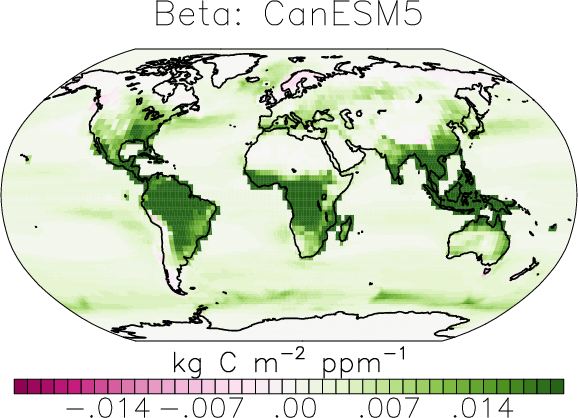

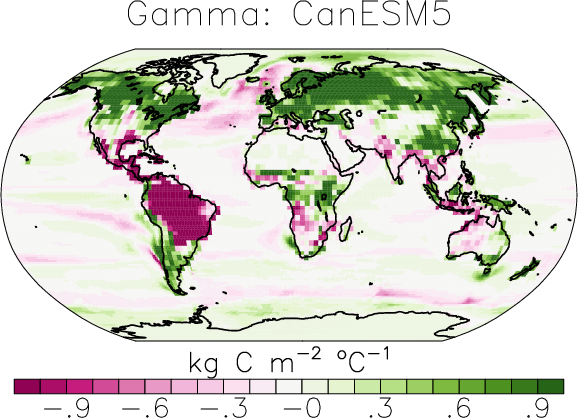

0.0027705938473016494
-0.052920062590067395
 


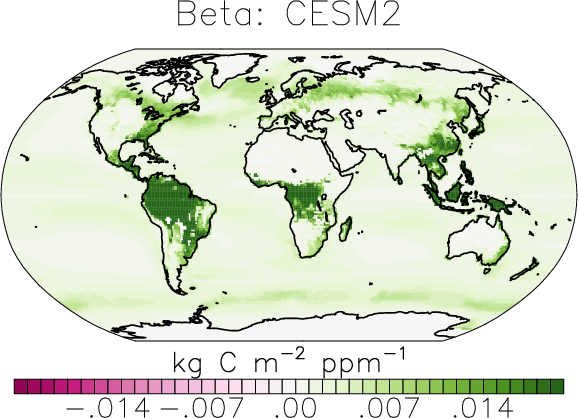

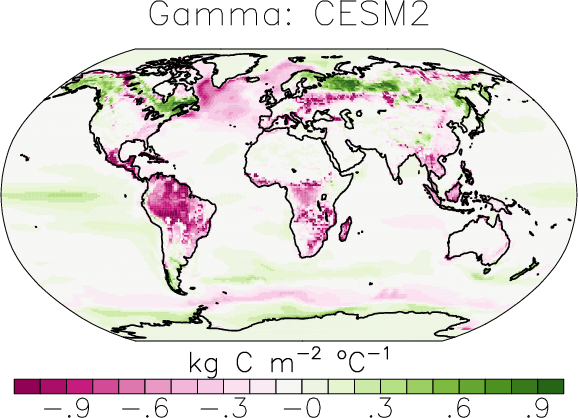

0.004437632224364486
-0.19658358200124137
 


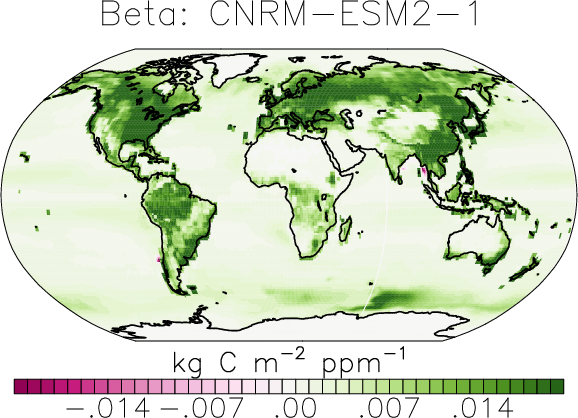

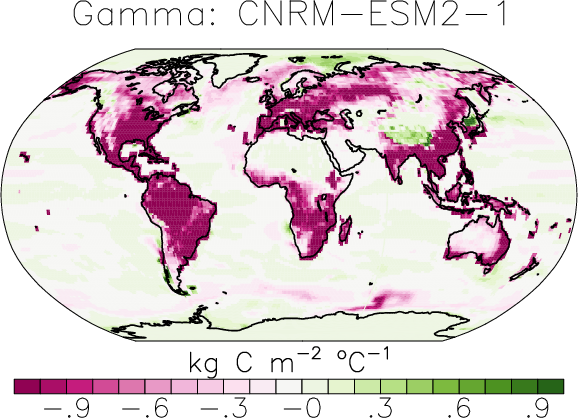

49953094.5358682
-1829251605.3306677
 


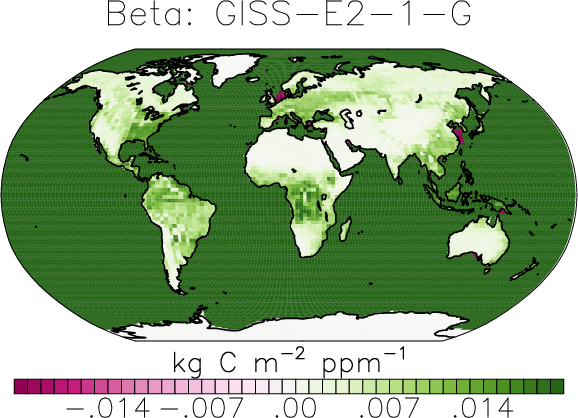

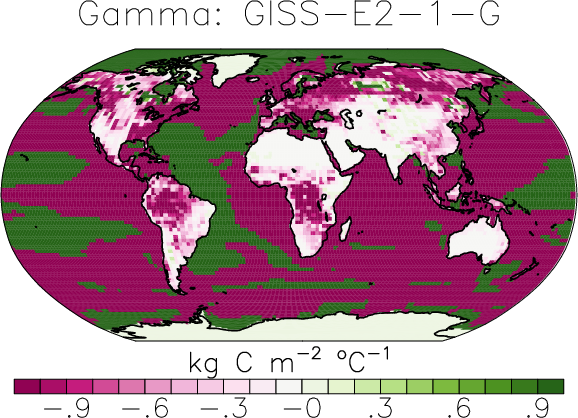

In [11]:
beta_all = np.zeros([nmodels, JM_o, IM_o])
gamma_all = np.zeros([nmodels, JM_o, IM_o])

beta_land_all = np.zeros([nmodels, JM_o, IM_o])
gamma_land_all = np.zeros([nmodels, JM_o, IM_o])

beta_ocean_all = np.zeros([nmodels, JM_o, IM_o])
gamma_ocean_all = np.zeros([nmodels, JM_o, IM_o])

for model_i in range(nmodels):
    beta = (beta_land_regridded_maps[model_i] + beta_ocean_regridded_maps[model_i]).compute()
    gamma = (gamma_land_regridded_maps[model_i] + gamma_ocean_regridded_maps[model_i]).compute()
    #
    print(beta.mean())
    print(gamma.mean())
    #
    beta_all[model_i,:,:] = beta
    gamma_all[model_i,:,:] = gamma
    #
    map_funcs.fill(beta, regrid_lats, regrid_lons, showjupyter=True, levels=colorbar_levels_beta, colormap='MPL_PiYG', projection='Robinson', title='Beta: '+models_list[model_i], subtitle = 'kg C m~S~-2~N~ ppm~S~-1~N~')
    map_funcs.fill(gamma, regrid_lats, regrid_lons, showjupyter=True, levels=colorbar_levels_gamma, colormap='MPL_PiYG', projection='Robinson', title='Gamma: '+models_list[model_i], subtitle = 'kg C m~S~-2~N~ ~S~o~N~C~S~-1~N~')  
    #
    beta_land_all[model_i,:,:] = beta_land_regridded_maps[model_i].compute()
    gamma_land_all[model_i,:,:] = gamma_land_regridded_maps[model_i].compute()
    #
    beta_ocean_all[model_i,:,:] = beta_ocean_regridded_maps[model_i].compute()
    gamma_ocean_all[model_i,:,:] = gamma_ocean_regridded_maps[model_i].compute()




0.002868690331095546
-0.17715323140853811
 


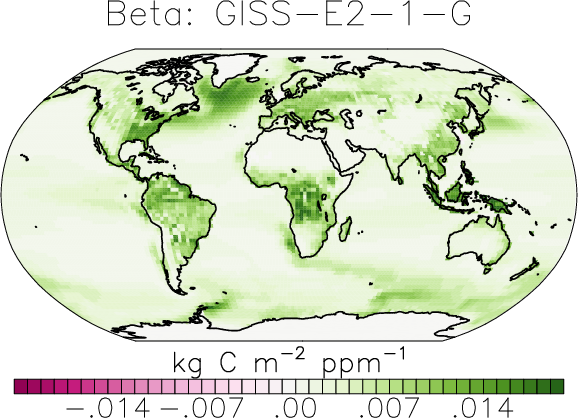

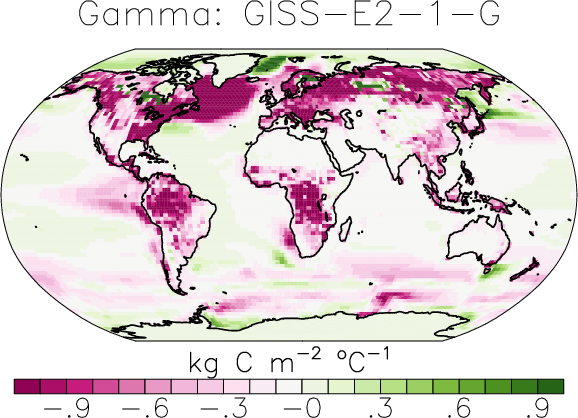

In [26]:
### apply unit correction to GISS ocean flux fields?
giss_ocn_unit_correction = 1./(1e3*86400.*365.)

for model_i in range(nmodels-1, nmodels):
    model_i = nmodels-1
    beta = (beta_land_regridded_maps[model_i] + beta_ocean_regridded_maps[model_i]*giss_ocn_unit_correction).compute()
    gamma = (gamma_land_regridded_maps[model_i] + gamma_ocean_regridded_maps[model_i]*giss_ocn_unit_correction).compute()
    #
    print(beta.mean())
    print(gamma.mean())
    #
    beta_all[model_i,:,:] = beta
    gamma_all[model_i,:,:] = gamma
    #
    map_funcs.fill(beta, regrid_lats, regrid_lons, showjupyter=True, levels=colorbar_levels_beta, colormap='MPL_PiYG', projection='Robinson', title='Beta: '+models_list[model_i], subtitle = 'kg C m~S~-2~N~ ppm~S~-1~N~')
    map_funcs.fill(gamma, regrid_lats, regrid_lons, showjupyter=True, levels=colorbar_levels_gamma, colormap='MPL_PiYG', projection='Robinson', title='Gamma: '+models_list[model_i], subtitle = 'kg C m~S~-2~N~ ~S~o~N~C~S~-1~N~')
    #
    beta_land_all[model_i,:,:] = beta_land_regridded_maps[model_i].compute()
    gamma_land_all[model_i,:,:] = gamma_land_regridded_maps[model_i].compute()
    #
    beta_ocean_all[model_i,:,:] = beta_ocean_regridded_maps[model_i].compute()*giss_ocn_unit_correction
    gamma_ocean_all[model_i,:,:] = gamma_ocean_regridded_maps[model_i].compute()*giss_ocn_unit_correction




In [27]:
beta_mean = beta_all.mean(axis=0)
gamma_mean = gamma_all.mean(axis=0)

beta_land_mean = beta_land_all.mean(axis=0)
beta_ocean_mean = beta_ocean_all.mean(axis=0)

gamma_land_mean = gamma_land_all.mean(axis=0)
gamma_ocean_mean = gamma_ocean_all.mean(axis=0)

1.6.1
 


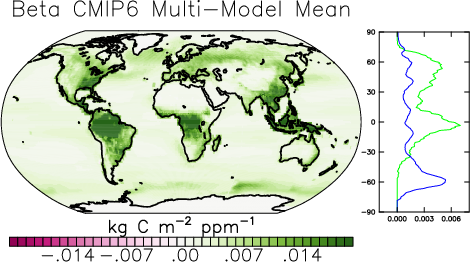

In [53]:
import importlib
importlib.reload(map_funcs)

n_zonalmean_curves = 2
zonalmean_beta_curves = np.zeros([n_zonalmean_curves,JM_o])
zonalmean_beta_curves[0,:] = beta_land_mean.mean(axis=1)
zonalmean_beta_curves[1,:] = beta_ocean_mean.mean(axis=1)

map_funcs.fill(beta_mean, regrid_lats, regrid_lons, showjupyter=True, levels=colorbar_levels_beta, colormap='MPL_PiYG', projection='Robinson', title='Beta CMIP6 Multi-Model Mean', subtitle = 'kg C m~S~-2~N~ ppm~S~-1~N~', plot_lat_profiles=zonalmean_beta_curves, plot_lat_profile_colors=['green','blue'])



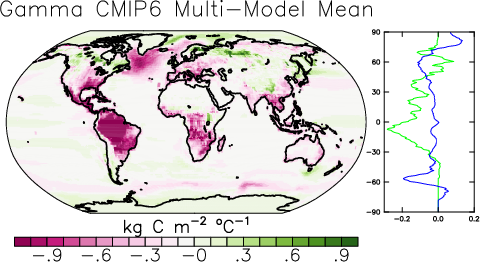

In [54]:
zonalmean_gamma_curves = np.zeros([n_zonalmean_curves,JM_o])
zonalmean_gamma_curves[0,:] = gamma_land_mean.mean(axis=1)
zonalmean_gamma_curves[1,:] = gamma_ocean_mean.mean(axis=1)


map_funcs.fill(gamma_mean, regrid_lats, regrid_lons, showjupyter=True, levels=colorbar_levels_gamma, colormap='MPL_PiYG', projection='Robinson', title='Gamma CMIP6 Multi-Model Mean', subtitle = 'kg C m~S~-2~N~ ~S~o~N~C~S~-1~N~', plot_lat_profiles=zonalmean_gamma_curves, plot_lat_profile_colors=['green','blue'])



In [16]:
giss_ocn_unit_correction


3.1709791983764586e-11